In [ ]:
%pip install pykan
%pip install torchinfo

# **KAN**

checkpoint directory created: ./model
saving model version 0.0
Estimated FLOPs for the KAN model: 171.0


| train_loss: 1.03e+01 | test_loss: 1.00e+01 | reg: 1.65e+01 | :   5%| | 24/500 [00:00<00:02, 234.86

| train_loss: 4.19e-01 | test_loss: 4.18e-01 | reg: 1.64e+01 | : 100%|█| 500/500 [00:01<00:00, 272.3


saving model version 0.1

Mean Squared Error on Test Data: 0.1743
Learned symbolic formula: 0


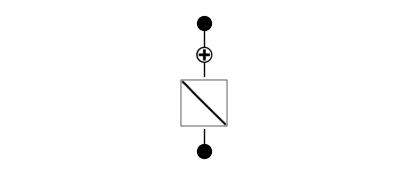

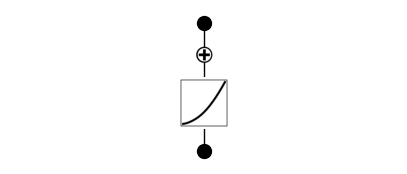

In [42]:
import pandas as pd
import torch
from kan import KAN
from kan.utils import create_dataset, ex_round

# Step 1: Load the Dataset
df = pd.read_csv('datasets/numsquares.csv')
x = torch.tensor(df[['number']].values, dtype=torch.float32)
y = torch.tensor(df[['square']].values, dtype=torch.float32)

# Create the dataset dictionary
dataset = {
    'train_input': x,
    'train_label': y,
    'test_input': x,   # Using the same data for simplicity in testing accuracy
    'test_label': y
}

# Step 2: Initialize the Model with only one neuron (input to output)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
din = 1
dout = 1
G = 2
K = 3
model = KAN(width=[1, 1], grid=G, k=K, seed=0, device=device)  # Single input-output neuron

# FLOP calculation function
def calculate_kan_flops(din, dout, G, K):
    return (din * dout) * (9 * K * (G + 1.5 * K) + 2 * G - 2.5 * K - 1)

# Calculate FLOPs for this KAN model
flops = calculate_kan_flops(din, dout, G, K)
print(f"Estimated FLOPs for the KAN model: {flops}")

# Visualize the initial model
model(dataset['train_input'])
model.plot()

# Step 3: Train the Model
# Training for 500 steps with Adam optimizer and lambda regularization
model.fit(dataset, opt="Adam", steps=500, lamb=0.0001)

# Visualize the trained model
model.plot()

# Step 4: Evaluate the Model (Mean Squared Error)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(dataset['test_input'])
    mse_loss = torch.nn.functional.mse_loss(predictions, dataset['test_label'])
    print(f"\nMean Squared Error on Test Data: {mse_loss.item():.4f}")

# Step 5: Display the Learned Symbolic Formula
symbolic_formula = ex_round(model.symbolic_formula()[0][0], 4)
print("Learned symbolic formula:", symbolic_formula)



# **MLP**

In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Step 1: Load the Dataset
df = pd.read_csv('datasets/numsquares.csv')
x = torch.tensor(df[['number']].values, dtype=torch.float32)
y = torch.tensor(df[['square']].values, dtype=torch.float32)

# Step 2: Define the MLP Model with Customizable Parameters
class MLP(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_hidden_layers=1):
        super(MLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        
        # Create the sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize the model with desired parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
hidden_size = 10000
output_size = 1
num_hidden_layers = 1
model = MLP(input_size, hidden_size, output_size, num_hidden_layers).to(device)

# Move data to the device
x, y = x.to(device), y.to(device)

# Calculate FLOPs manually
def calculate_flops(model, input_size):
    flops = 0
    for layer in model.model:
        if isinstance(layer, nn.Linear):
            layer_flops = 2 * layer.in_features * layer.out_features
            flops += layer_flops
    return flops

# Display the calculated FLOPs for this model
flops = calculate_flops(model, input_size)
print(f"Estimated FLOPs for the MLP model: {flops}")

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the Model
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()               # Clear gradients
    predictions = model(x)              # Forward pass
    loss = criterion(predictions, y)    # Calculate loss
    loss.backward()                     # Backward pass
    optimizer.step()                    # Update weights

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 5: Evaluate the Model (Mean Squared Error)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(x)
    mse_loss = criterion(predictions, y)
    print(f"\nMean Squared Error on Test Data: {mse_loss.item():.4f}")

# Convert predictions to numpy for easy comparison
predictions_np = predictions.cpu().numpy()
y_np = y.cpu().numpy()

# Display Predictions vs Actual Values
print("\nPredictions vs Actual:")
for i in range(len(y_np)):
    print(f"Number: {x[i].item()}, Predicted Square: {predictions_np[i][0]:.2f}, Actual Square: {y_np[i][0]}")


Estimated FLOPs for the MLP model: 40000
Epoch [100/500], Loss: 18.0602


Epoch [200/500], Loss: 2.5107
Epoch [300/500], Loss: 0.8949
Epoch [400/500], Loss: 1.4201
Epoch [500/500], Loss: 0.3416

Mean Squared Error on Test Data: 0.6646

Predictions vs Actual:
Number: 1.0, Predicted Square: 1.42, Actual Square: 1.0
Number: 2.0, Predicted Square: 4.01, Actual Square: 4.0
Number: 3.0, Predicted Square: 9.48, Actual Square: 9.0
Number: 4.0, Predicted Square: 16.52, Actual Square: 16.0
Number: 5.0, Predicted Square: 25.46, Actual Square: 25.0
Number: 6.0, Predicted Square: 36.58, Actual Square: 36.0
Number: 7.0, Predicted Square: 49.54, Actual Square: 49.0
Number: 8.0, Predicted Square: 64.64, Actual Square: 64.0
Number: 9.0, Predicted Square: 81.59, Actual Square: 81.0
Number: 10.0, Predicted Square: 100.82, Actual Square: 100.0
Number: 11.0, Predicted Square: 121.37, Actual Square: 121.0
Number: 12.0, Predicted Square: 145.08, Actual Square: 144.0
Number: 13.0, Predicted Square: 170.71, Actual Square: 169.0
Number: 14.0, Predicted Square: 197.43, Actual Square: 